# ⚛️ H₂ VQE From Scratch  
## **Manual UCCSD → Engine Layer → Package (`vqe.core.run_vqe`)**

This notebook provides a complete, educational walkthrough of **Variational Quantum
Eigensolver (VQE)** applied to the **H₂ molecule**.

---
## **Part 1 — Manual VQE (Educational, From Scratch)**
You will:
- Build the molecular Hamiltonian  
- Compute Hartree–Fock reference  
- Extract UCCSD single & double excitations  
- Construct a manual UCCSD ansatz  
- Optimize using several PennyLane optimizers  
- Inspect the final ground-state amplitudes  

This mirrors what your `vqe.engine` does internally, but presented step-by-step.

---
## **Part 2 — Using the Packaged VQE API (`vqe.core.run_vqe`)**

You will repeat the same problem using:

```python
from vqe.core import run_vqe
```

The package handles:
- device creation  
- ansatz selection  
- optimizer construction  
- caching  
- plotting  
- final state extraction  

---
Together, these sections provide both:
- **conceptual understanding** of VQE, and  
- **practical usage** of your production-ready VQE implementation.


In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt

# Package imports for Part 2
from vqe.core import run_vqe
from vqe.visualize import plot_convergence
from vqe.optimizer import get_optimizer
from vqe.ansatz import uccsd_ansatz, init_params

# 🟦 Part 1 — Manual VQE Implementation (Educational UCCSD)

In this section we rebuild the VQE procedure step-by-step.

### Steps:
1. Build Hamiltonian  
2. Hartree–Fock reference  
3. Compute UCCSD excitations  
4. Define UCCSD ansatz manually  
5. Construct cost function  
6. Optimize with several PennyLane optimizers  
7. Inspect final state  


In [2]:
# Molecular configuration
symbols = ["H", "H"]
coordinates = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.7414],
])
basis = "sto-3g"
electrons = 2

# Build Hamiltonian
H, num_qubits = qchem.molecular_hamiltonian(symbols, coordinates, basis=basis, charge=0)
print("Number of qubits:", num_qubits)

# Hartree–Fock reference
hf = qchem.hf_state(electrons, num_qubits)
print("HF state:", hf)

Number of qubits: 4
HF state: [1 1 0 0]


In [3]:
dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev)
def hf_energy(state):
    qml.BasisState(state, wires=range(num_qubits))
    return qml.expval(H)

print("HF Energy:", float(hf_energy(hf)))

HF Energy: -0.8884230416458276


In [4]:
# Extract UCCSD excitations
singles, doubles = qchem.excitations(electrons, 2 * qchem.Molecule(symbols, coordinates).n_orbitals)
print("Singles:", singles)
print("Doubles:", doubles)

n_params = len(singles) + len(doubles)
print("Total UCCSD parameters:", n_params)

Singles: [[0, 2], [1, 3]]
Doubles: [[0, 1, 2, 3]]
Total UCCSD parameters: 3


In [5]:
# --- Manual UCCSD Ansatz ---
def manual_uccsd(params, wires):
    """Educational UCCSD ansatz (single + double excitations)."""
    # HF reference
    qml.BasisState(hf, wires=wires)

    # Singles
    idx = 0
    for exc in singles:
        qml.SingleExcitation(params[idx], wires=list(exc))
        idx += 1

    # Doubles
    for exc in doubles:
        qml.DoubleExcitation(params[idx], wires=list(exc))
        idx += 1


@qml.qnode(dev)
def cost(params):
    manual_uccsd(params, wires=range(num_qubits))
    return qml.expval(H)

## 🔧 Manual VQE Optimization
We now optimize the UCCSD parameters using different classical optimizers.

We compare:
- Adam  
- Gradient Descent  
- Momentum  
- Nesterov  
- Adagrad  
- SPSA  

In [6]:
optimizers = ["Adam", "GradientDescent", "Momentum", "Nesterov", "Adagrad", "SPSA"]

max_iters = 50
stepsize = 0.1
results_manual = {}

for opt_name in optimizers:
    print(f"\nRunning manual VQE with optimizer: {opt_name}")

    params = np.zeros(n_params, requires_grad=True)
    opt = get_optimizer(opt_name, stepsize)

    energies = [float(cost(params))]

    for _ in range(max_iters):
        params, prev = opt.step_and_cost(cost, params)
        energies.append(float(prev))

    results_manual[opt_name] = {
        "energies": energies,
        "params": params,
    }


Running manual VQE with optimizer: Adam

Running manual VQE with optimizer: GradientDescent

Running manual VQE with optimizer: Momentum

Running manual VQE with optimizer: Nesterov

Running manual VQE with optimizer: Adagrad

Running manual VQE with optimizer: SPSA


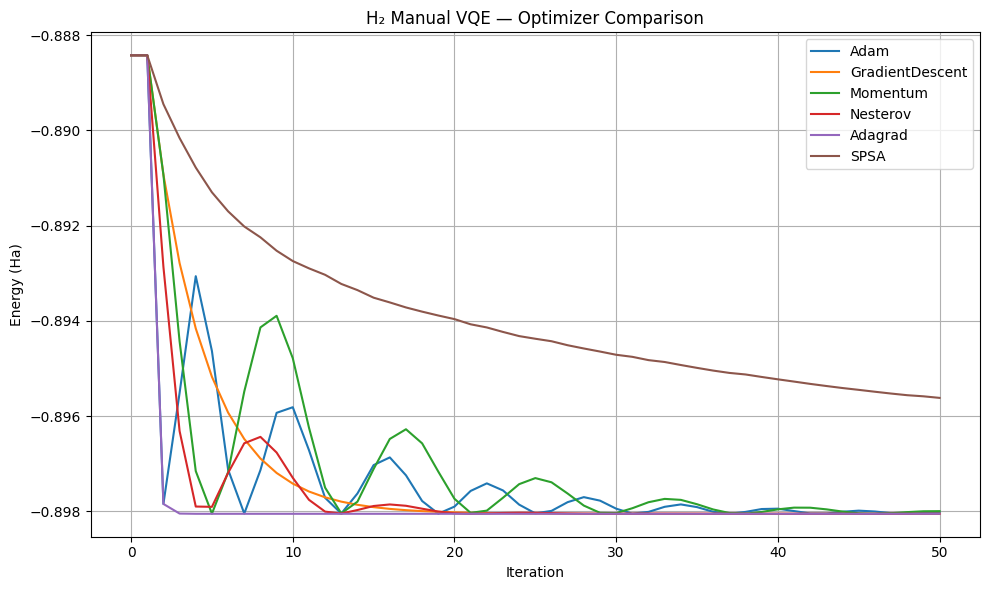

In [7]:
# Plot manual optimizer comparison
plt.figure(figsize=(10,6))
for name, data in results_manual.items():
    plt.plot(data["energies"], label=name)

plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H₂ Manual VQE — Optimizer Comparison")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# Extract best-performing optimizer
best_manual_opt = min(results_manual, key=lambda n: results_manual[n]["energies"][-1])
best_params = results_manual[best_manual_opt]["params"]

print("Best manual optimizer:", best_manual_opt)

@qml.qnode(dev)
def final_state_manual(params):
    manual_uccsd(params, wires=range(num_qubits))
    return qml.state()

psi_manual = final_state_manual(best_params)

nz = np.where(np.abs(psi_manual) > 1e-2)[0]
print("\nSignificant amplitudes:")
for idx in nz:
    print(f"|{idx:0{num_qubits}b}⟩ :", psi_manual[idx])

Best manual optimizer: Adagrad

Significant amplitudes:
|0011⟩ : (-0.05854512719726701+0j)
|1100⟩ : (0.9982847630217822+0j)


## 📊 Manual State Amplitudes
Bar plot of populated computational basis states.

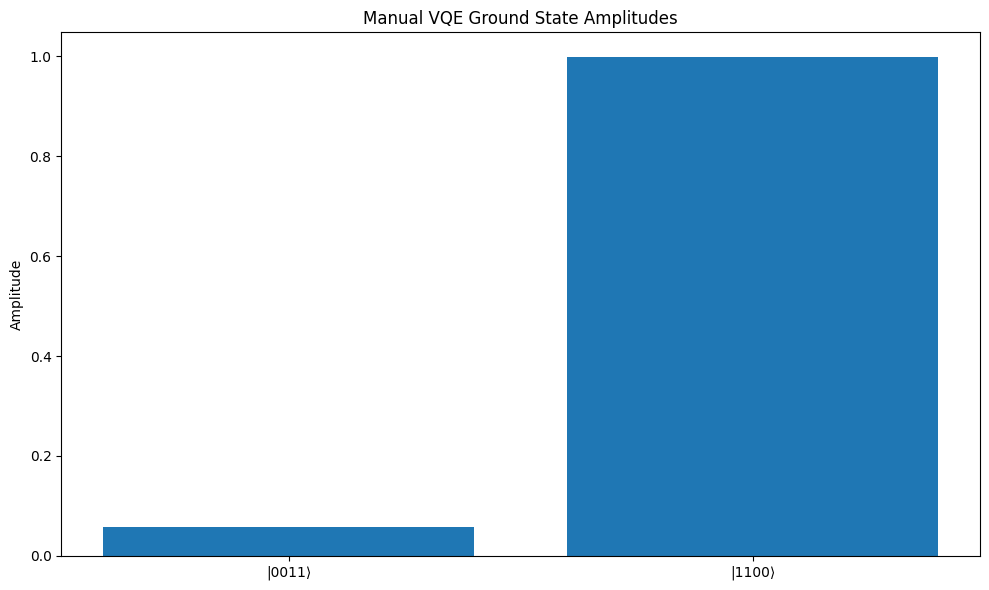

In [9]:
labels = [f"|{i:0{num_qubits}b}⟩" for i in nz]
amps = np.abs(psi_manual[nz])

plt.figure(figsize=(10,6))
plt.bar(labels, amps)
plt.ylabel("Amplitude")
plt.title("Manual VQE Ground State Amplitudes")
plt.tight_layout()
plt.show()

# 🟩 Part 2 — Using the Packaged VQE API (`run_vqe`)

Now we solve the **same** H₂ VQE problem using your production-ready module:

```python
from vqe.core import run_vqe
```

Benefits:
- Automatic device setup  
- Automatic UCCSD parameter initialisation  
- Automatic plotting  
- Optional noise models  
- Automatic JSON + image output  


In [10]:
results_pkg = {}

for opt_name in optimizers:
    print(f"\nRunning run_vqe with optimizer: {opt_name}")

    rec = run_vqe(
        molecule="H2",
        ansatz_name="UCCSD",
        optimizer_name=opt_name,
        n_steps=50,
        stepsize=0.1,
        noisy=False,
        plot=False,
        seed=0,
    )

    results_pkg[opt_name] = rec["energies"]


Running run_vqe with optimizer: Adam
Step 01/50: E = -1.116684 Ha
Step 02/50: E = -1.130847 Ha
Step 03/50: E = -1.136877 Ha
Step 04/50: E = -1.135237 Ha
Step 05/50: E = -1.132884 Ha
Step 06/50: E = -1.130189 Ha
Step 07/50: E = -1.130359 Ha
Step 08/50: E = -1.132787 Ha
Step 09/50: E = -1.135308 Ha
Step 10/50: E = -1.136567 Ha
Step 11/50: E = -1.136746 Ha
Step 12/50: E = -1.136376 Ha
Step 13/50: E = -1.135604 Ha
Step 14/50: E = -1.134736 Ha
Step 15/50: E = -1.134468 Ha
Step 16/50: E = -1.135114 Ha
Step 17/50: E = -1.136147 Ha
Step 18/50: E = -1.136879 Ha
Step 19/50: E = -1.137096 Ha
Step 20/50: E = -1.136974 Ha
Step 21/50: E = -1.136692 Ha
Step 22/50: E = -1.136369 Ha
Step 23/50: E = -1.136152 Ha
Step 24/50: E = -1.136200 Ha
Step 25/50: E = -1.136537 Ha
Step 26/50: E = -1.136970 Ha
Step 27/50: E = -1.137233 Ha
Step 28/50: E = -1.137210 Ha
Step 29/50: E = -1.137025 Ha
Step 30/50: E = -1.136862 Ha
Step 31/50: E = -1.136794 Ha
Step 32/50: E = -1.136815 Ha
Step 33/50: E = -1.136927 Ha
Step 

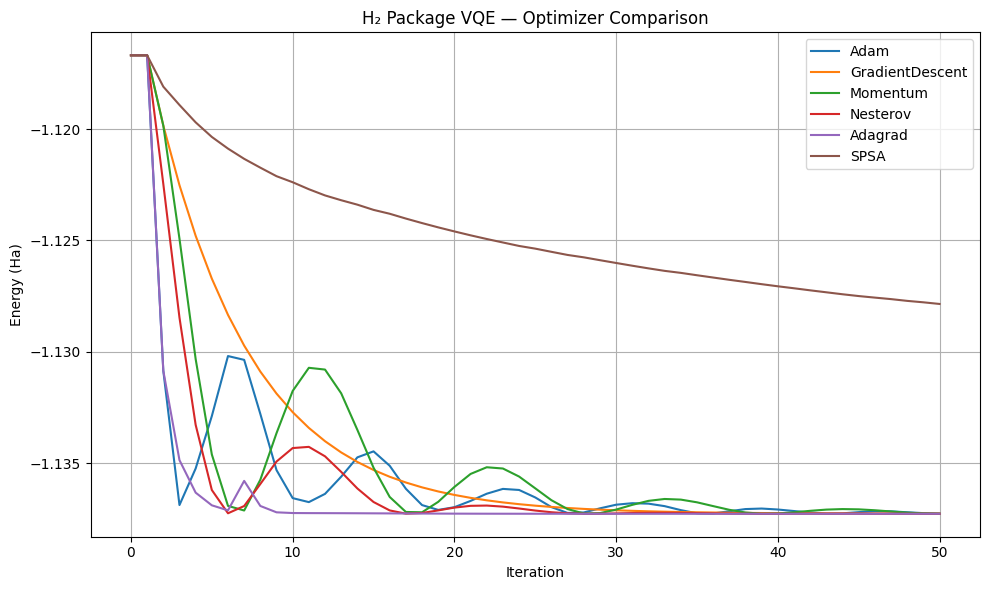

In [11]:
# Plot package optimizer comparison
plt.figure(figsize=(10,6))
for name, energies in results_pkg.items():
    plt.plot(energies, label=name)

plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H₂ Package VQE — Optimizer Comparison")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
best_pkg_opt = min(results_pkg, key=lambda n: results_pkg[n][-1])
print("Best package optimizer:", best_pkg_opt)

res = run_vqe(
    molecule="H2",
    ansatz_name="UCCSD",
    optimizer_name=best_pkg_opt,
    n_steps=50,
    stepsize=0.1,
    noisy=False,
    plot=False,
    seed=0,
)

psi_pkg = np.array(res["final_state_real"]) + 1j * np.array(res["final_state_imag"])
nz_pkg = np.where(np.abs(psi_pkg) > 1e-2)[0]

print("\nSignificant amplitudes (Package):")
for idx in nz_pkg:
    print(f"|{idx:0{num_qubits}b}⟩ :", psi_pkg[idx])

Best package optimizer: Adagrad

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adagrad__VQE__noiseless__s0__f28ab4037d46.json

Significant amplitudes (Package):
|0011⟩ : (-0.11282736848339227+0j)
|1100⟩ : (0.9936146054753315+0j)


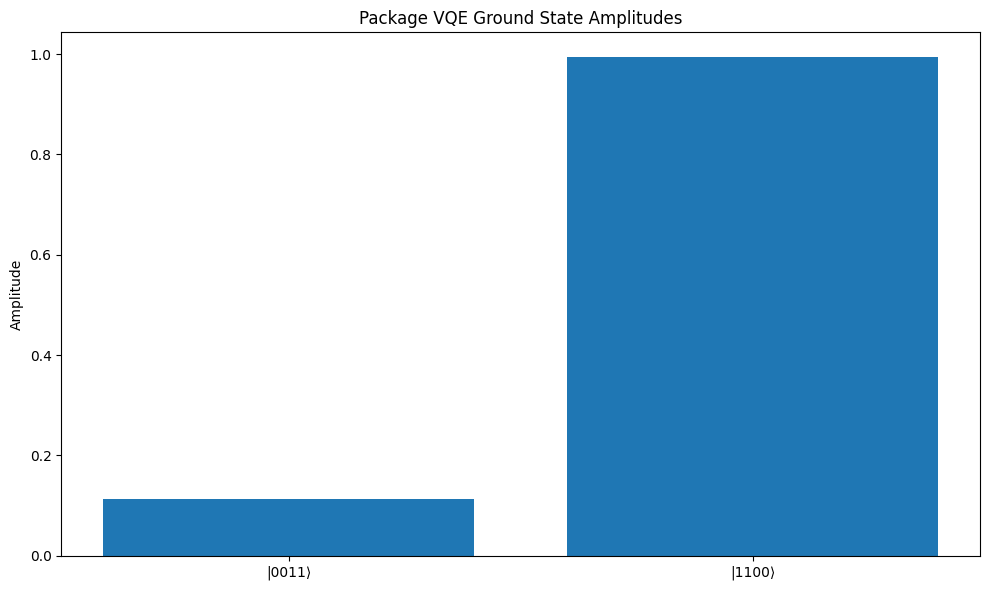

In [13]:
labels = [f"|{i:0{num_qubits}b}⟩" for i in nz_pkg]
amps = np.abs(psi_pkg[nz_pkg])

plt.figure(figsize=(10,6))
plt.bar(labels, amps)
plt.ylabel("Amplitude")
plt.title("Package VQE Ground State Amplitudes")
plt.tight_layout()
plt.show()